In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
SEED=2
import os

train=pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
submition=pd.read_csv("/kaggle/input/aptos2019-blindness-detection/test.csv")

x = train['id_code']
y = train['diagnosis']

x,y=shuffle(x,y)
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
df_X,X_test,df_y,y_test=train_test_split(x, y, test_size=0.15)

X_train,X_valid,y_train,y_valid=train_test_split(df_X, df_y, test_size=0.15)


In [3]:
def load_ben_color(path, sigmaX=20):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [4]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [5]:
import matplotlib.pyplot as plt 
import cv2
train_images=[]
IMG_SIZE=224
%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(X_train):
    
    path=f"../input/aptos2019-blindness-detection/train_images/{row}.png"
    image =load_ben_color(path)
    train_images.append(image)

        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


<Figure size 1800x1152 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt 
import cv2
test_images=[]
IMG_SIZE=224
%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(X_test):
    
    path=f"../input/aptos2019-blindness-detection/train_images/{row}.png"
    image =load_ben_color(path)
    test_images.append(image)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


<Figure size 1800x1152 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt 
import cv2
valid_images=[]
IMG_SIZE=224
%time
fig = plt.figure(figsize=(25, 16))

for idx, row in enumerate(X_valid):
    
    path=f"../input/aptos2019-blindness-detection/train_images/{row}.png"
    image =load_ben_color(path)
    valid_images.append(image)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


<Figure size 1800x1152 with 0 Axes>

In [8]:

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
NUM_CLASSES=5

In [9]:
from keras.utils import to_categorical
y_train_dummies=to_categorical(y_train,num_classes=NUM_CLASSES)
y_test_dummies=to_categorical(y_test,num_classes=NUM_CLASSES)
y_valid_dummies=to_categorical(y_valid,num_classes=NUM_CLASSES)
y_train_dummies

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [10]:
import numpy as np
import time
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
import os




In [11]:
num_Classes=5

train=np.array(train_images)
test=np.array(test_images)
valid=np.array(valid_images)

num_of_samples=train.shape[0]
train.shape

(2645, 224, 224, 3)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train)
datagen_valid.fit(valid)

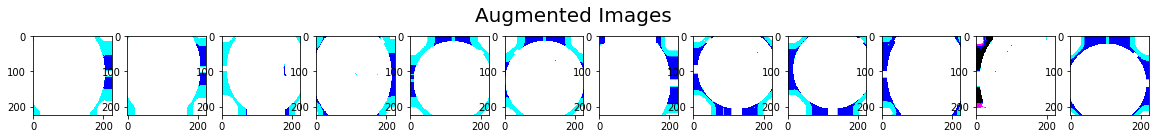

In [13]:

import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = train[:12]
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

In [33]:
from keras.preprocessing import image                  
image_input=Input(shape=train.shape[1:])
model=VGG16(input_tensor=image_input, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [35]:


last_layer=model.get_layer('fc1').output
last_layer=Dropout(0.2)(last_layer)

last_layer=Dense(1024)(last_layer)
last_layer=BatchNormalization()(last_layer)
last_layer=Activation('relu')(last_layer)
last_layer=last_layer=Dropout(0.2)(last_layer)
last_layer=Dense(512, activation='relu')(last_layer)
last_layer=BatchNormalization()(last_layer)
last_layer=Activation('relu')(last_layer)
last_layer=Dropout(0.2)(last_layer)

out=Dense(num_Classes,activation='softmax', name='output')(last_layer)

custom_vgg_model=Model(image_input,out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [36]:
for layer in custom_vgg_model.layers[:-10]:
    layer.trainable=False

In [37]:
custom_vgg_model.compile(loss="categorical_crossentropy", optimizer='Adam',  metrics=['accuracy'])


In [39]:

t=time.time()

custom_vgg_model.fit_generator(datagen_train.flow(train, y_train_dummies, batch_size=batch_size),
                    steps_per_epoch=train.shape[0]/32,
                    epochs=2, verbose=2,
                    validation_data=datagen_valid.flow(valid, y_valid_dummies, batch_size=batch_size),validation_steps=valid.shape[0]/32)
print("training time: %s" %(t-time.time()))

Epoch 1/2
 - 35s - loss: 0.4052 - acc: 0.8456 - val_loss: 0.6293 - val_acc: 0.7537
Epoch 2/2
 - 34s - loss: 0.3727 - acc: 0.8610 - val_loss: 0.7088 - val_acc: 0.7623
training time: -69.50976991653442


In [40]:
batch_size = 32
epochs = 100


t=time.time()

custom_vgg_model.fit_generator(datagen_train.flow(train, y_train_dummies, batch_size=batch_size),
                    steps_per_epoch=train.shape[0]/16,
                    epochs=40, verbose=2,
                    validation_data=datagen_valid.flow(valid, y_valid_dummies, batch_size=batch_size),validation_steps=valid.shape[0]/16)
print("training time: %s" %(t-time.time()))

Epoch 1/40
 - 73s - loss: 0.3862 - acc: 0.8500 - val_loss: 0.6768 - val_acc: 0.7752
Epoch 2/40
 - 68s - loss: 0.3836 - acc: 0.8554 - val_loss: 0.6409 - val_acc: 0.7730
Epoch 3/40
 - 68s - loss: 0.3562 - acc: 0.8657 - val_loss: 0.7105 - val_acc: 0.7709
Epoch 4/40
 - 67s - loss: 0.3499 - acc: 0.8679 - val_loss: 0.6904 - val_acc: 0.7816
Epoch 5/40
 - 69s - loss: 0.3508 - acc: 0.8602 - val_loss: 0.6379 - val_acc: 0.7762
Epoch 6/40
 - 68s - loss: 0.3379 - acc: 0.8685 - val_loss: 0.7589 - val_acc: 0.7591
Epoch 7/40
 - 68s - loss: 0.3443 - acc: 0.8641 - val_loss: 0.7082 - val_acc: 0.7762
Epoch 8/40
 - 68s - loss: 0.3231 - acc: 0.8717 - val_loss: 0.6380 - val_acc: 0.7901
Epoch 9/40
 - 68s - loss: 0.3172 - acc: 0.8795 - val_loss: 0.6778 - val_acc: 0.7602
Epoch 10/40
 - 69s - loss: 0.3149 - acc: 0.8859 - val_loss: 0.7630 - val_acc: 0.7602
Epoch 11/40
 - 67s - loss: 0.3235 - acc: 0.8764 - val_loss: 0.6993 - val_acc: 0.7623
Epoch 12/40
 - 68s - loss: 0.2889 - acc: 0.8912 - val_loss: 0.7489 - val_a

In [21]:


t=time.time()

custom_vgg_model.fit(train,y_train_dummies, batch_size=32, epochs=30,verbose=1 ,validation_data=(valid,y_valid_dummies))

print("training time: %s" %(t-time.time()))

Train on 2645 samples, validate on 467 samples
Epoch 1/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.9699 - acc: 0.7905 - val_loss: 2.5098 - val_acc: 0.7773
Epoch 2/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.7895 - acc: 0.8178 - val_loss: 2.4016 - val_acc: 0.7794
Epoch 3/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.6607 - acc: 0.8257 - val_loss: 2.3419 - val_acc: 0.7859
Epoch 4/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.7067 - acc: 0.8223 - val_loss: 2.2510 - val_acc: 0.7666
Epoch 5/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.5239 - acc: 0.8329 - val_loss: 2.1065 - val_acc: 0.7773
Epoch 6/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.4916 - acc: 0.8378 - val_loss: 2.1745 - val_acc: 0.7837
Epoch 7/30
2645/2645 [==============================] - 8s 3ms/step - loss: 1.5039 - acc: 0.8423 - val_loss: 2.2255 - val_acc: 0.7816
Epoch 8/30
2645

In [41]:
(loss, accuracy)=custom_vgg_model.evaluate(test,y_test_dummies,verbose=1 ,batch_size=32)
print(loss)
print(accuracy*100)

550/550 [==============================] - 1s 3ms/step
0.9775662539222024
75.09090906923468


In [42]:
from tqdm import tqdm
predicted=[]
submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
    
    image = load_ben_color(path)
    image = cv2.resize(image, (224, 224))
    score_predict = model.predict((image[np.newaxis])/255)
    label_predict = np.argmax(score_predict)
    #label_predict = score_predict.astype(int).sum() - 1
    predicted.append(str(label_predict))

1928it [03:24,  9.44it/s]


In [43]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,669
1,003f0afdcd15,669
2,006efc72b638,669
3,00836aaacf06,669
4,009245722fa4,669
